In [1]:
#Conda imports
import numpy as np
from scipy.linalg import qr
import time
import random
import matplotlib.pyplot as plt
import itertools
from numpy.polynomial.chebyshev import chebroots, chebval
#from numalgsolve.TelenVanBarel import sorted_matrix_terms
from numalgsolve.utils import inverse_P, row_swap_matrix
from numalgsolve.utils import mon_combosHighest, slice_top, mon_combos
from scipy.misc import comb
#Local imports
from numalgsolve.polynomial import MultiCheb, MultiPower, getPoly
from scipy.linalg import eig
from numalgsolve.Division import division
from numalgsolve.Multiplication import multiplication
from numalgsolve.subdivision import good_zeros_nd, subdivision_solve_nd, solve
from  matplotlib import patches as patches

%matplotlib inline

# Auto-reload packages
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

def polyList(deg,dim,power,Type = 'standard',triangular = True):
    deg += 1
    coeffs = list()
    if Type == 'random':
        for i in range(dim):
            coeffs.append(np.random.random_sample(deg*np.ones(dim, dtype = int)))
    elif Type == 'int':
        Range = 1000
        for i in range(dim):
            coeffs.append(np.random.randint(-Range,Range,deg*np.ones(dim, dtype = int)))
    elif Type == 'standard':
        for i in range(dim):
            coeffs.append(np.random.standard_normal(deg*np.ones(dim, dtype = int)))
    if triangular:
        for i,j in np.ndenumerate(coeffs[0]):
            if np.sum(i) >= deg:
                for coeff in coeffs:
                    coeff[i] = 0
    polys = list()
    if power:
        for coeff in coeffs:
            polys.append(MultiPower(coeff))
    else:
        for coeff in coeffs:
            polys.append(MultiCheb(coeff))
    return polys

def evaluate(zero, polys, accuracy = 1.e-3):
    good = True
    outOfRange = False
    for poly in polys:
        if not np.isclose(0, poly.evaluate_at(zero), atol = accuracy):
            good = False
            if (np.abs(zero) > 1).any():
                outOfRange = True
            break
    return good,outOfRange

def checkZeros(zeros, polys, accuracy = 1.e-3):
    if zeros == -1:
        print(-1)
        return
    results = np.apply_along_axis(evaluate, 1, zeros, polys, accuracy = accuracy)
    correct = np.sum(results[:,0])
    outOfRange = np.sum(results[:,1])
    print("{} ZEROS ARE CORRECT OUT OF {}".format(correct, len(zeros)))
    print("{} of them were about of range".format(outOfRange))
    print("{} percent of zeros in range correct".format(np.round(100*correct/(len(zeros)-outOfRange),3)))

def coeffToString(matrix):
    result = ''
    for mon in zip(*np.where(matrix != 0)):
        coeff = matrix[mon]
        mon = mon[::-1]
        if coeff >= 0:
            monString = '+' + str(coeff) + '*'
        else:
            monString = str(coeff) + '*'
        for i in range(len(mon)):
            if mon[i] == 0:
                continue
            monString += 'x'
            monString += str(i)
            if mon[i] > 1:
                monString += '^'
                monString += str(mon[i])
            monString+= '*'
        #if monString[-1] == '*':
        monString = monString[:-1]
        result += monString
    if result[0] == '+':
        result = result[1:]
    return result

In [2]:
from numalgsolve.polynomial import cheb2poly
from subprocess import run
input_file_path = '../../BertiniApple32_v1.5.1/input'
output_file_path = 'finite_solutions'
bertini_run_process = ['../../BertiniApple32_v1.5.1/bertini', '../../BertiniApple32_v1.5.1/input']
def prep_bertini(polys):
    if isinstance(polys[0], MultiCheb):
        polysNew = []
        for poly in polys:
            polysNew.append(cheb2poly(poly))
        polys = polysNew
    num_polys = len(polys)
    function_string = 'function '
    for i in range(num_polys):
        function_string += 'f' + str(i) + ', '
    function_string = function_string[:-2] + ';' + '\n'
    dim = polys[0].dim
    variable_string = 'variable_group '
    for i in range(dim):
        variable_string += 'x' + str(i) + ', '
    variable_string = variable_string[:-2] + ';' + '\n'
    with open(input_file_path, 'w') as input_file:
        input_file.write(function_string)
        input_file.write(variable_string)
        for i in range(num_polys):
            input_file.write('f' + str(i) + ' = ' + coeffToString(polys[i].coeff) + ';\n')
        input_file.write('END;')

def bertini_results(dim):
    with open(output_file_path, 'r') as output_file:
        results = output_file.readlines()
    def get_number(line):
        nums = line.split(' ')
        return complex(float(nums[0]), float(nums[1]))

    #print(results)
    zeros = list()
    for i in range(2,len(results),dim+1):
        zero = np.zeros(dim, dtype = 'complex')
        for j in range(dim):
            zero[j] = get_number(results[i+dim-1-j])
        zeros.append(zero)
        #zeros.append(np.array([get_number(results[i+1]), get_number(results[i])]))
    return np.vstack(zeros)

def run_bertini(polys):
    prep_bertini(polys)
    run(bertini_run_process)
    return bertini_results(polys[0].dim)

def in_zeros(zeros, zero_to_check, tol = 1.e-5):
    for zero in zeros:
        if np.allclose(zero - zero_to_check,np.zeros_like(zero), atol=tol):
            return True
    return False

In [3]:
def run_trial(polys, method, tol = 1.e-5):
    zeros = pr.solve(polys, method=method)
    if not power:
        for i in range(len(polys)):
            polys[i] = cheb2poly(polys[i])
    zeros_bertini = run_bertini(polys)
    trial_results(zeros, zeros_bertini, tol = tol)

def trial_results(zerosTVB, zeros_bertini, tol = 1.e-5):
    print('TVB - {} out of {}'.format(np.sum([in_zeros(zerosTVB, zero_bertini, tol=tol)\
                                              for zero_bertini in zeros_bertini]),len(zeros_bertini)))
    min_mag = 1000
    for zero_bertini in zeros_bertini:
        if not in_zeros(zerosTVB, zero_bertini, tol=tol):
            min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
            assert(np.any(np.abs(zero_bertini) > 1))
    print(min_mag)

Notes 
- Division isn't working consistently on square stuff. Test more thoroughly when it works and when it doesn't.
    - Come up with a good criteria for when it should work.

In [103]:
deg = 25
dim = 2
power = True
polys = polyList(deg,dim,power,triangular=True)

In [105]:
%time zerosDiv = division(polys,divisor_var=0)
real_zeros = zerosDiv[np.sum(np.imag(zerosDiv) == 0, axis = 1) == dim]
real_zeros = real_zeros[np.sum(np.abs(real_zeros) <= 1, axis = 1) == dim]
real_zeros

CPU times: user 1.74 s, sys: 46.9 ms, total: 1.79 s
Wall time: 1.04 s


array([[ 0.08315472-0.j,  0.67736312-0.j],
       [ 0.50559283+0.j,  0.79099329+0.j],
       [ 0.86070760-0.j,  0.82167172-0.j],
       [ 0.94875934-0.j,  0.25131118-0.j]])

In [106]:
%time zerosDiv = division(polys,divisor_var=1)
real_zeros = zerosDiv[np.sum(np.imag(zerosDiv) == 0, axis = 1) == dim]
real_zeros = real_zeros[np.sum(np.abs(real_zeros) <= 1, axis = 1) == dim]
real_zeros

CPU times: user 1.83 s, sys: 51.9 ms, total: 1.88 s
Wall time: 1.16 s


array([[ 0.94875934-0.j,  0.25131118-0.j],
       [ 0.08315472-0.j,  0.67736312-0.j],
       [ 0.50559283+0.j,  0.79099329+0.j],
       [ 0.86070760+0.j,  0.82167172+0.j]])

In [ ]:
array([[ 0.86072104+0.j,  0.82166481+0.j],
       [ 0.94875781+0.j,  0.25131542+0.j],
       [ 0.50556876+0.j,  0.79097875+0.j],
       [ 0.08323071+0.j,  0.67741142+0.j]])

array([[ 0.86072104+0.j,  0.82166481+0.j],
       [ 0.94875781+0.j,  0.25131542+0.j],
       [ 0.50556876+0.j,  0.79097875+0.j],
       [ 0.08323071+0.j,  0.67741142+0.j]])

Total intervals checked was 154
Methods used were ['constant_term_check', 'full_quad_check', 'linear_check', 'Division']
The percent solved by each was [ 79.22   5.84   5.84   9.09]


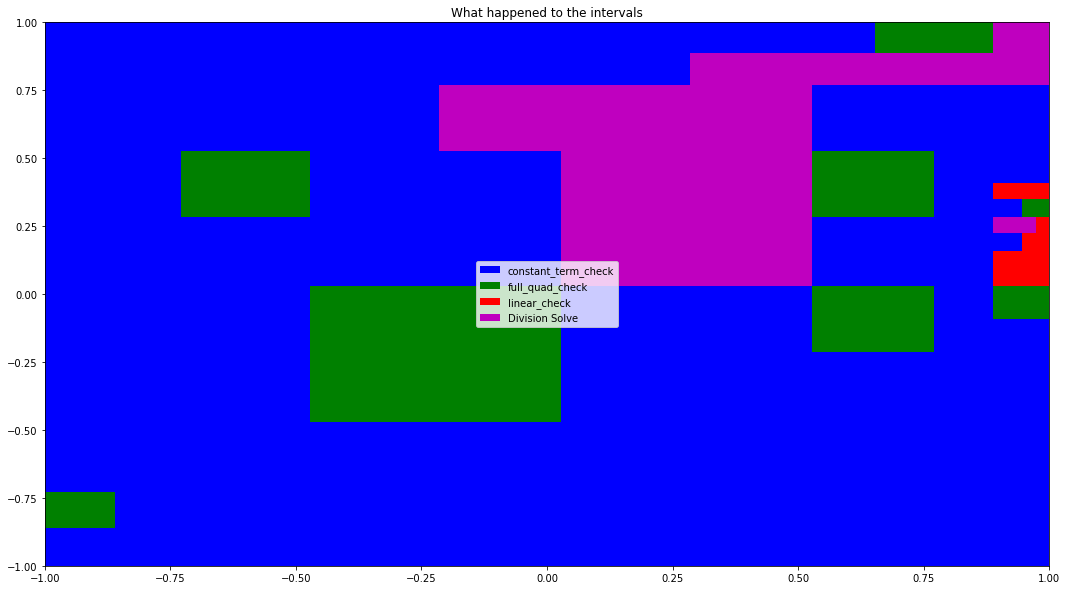

CPU times: user 1.59 s, sys: 32.9 ms, total: 1.62 s
Wall time: 1.38 s


array([[ 0.86072104+0.j,  0.82166481+0.j],
       [ 0.94875781+0.j,  0.25131542+0.j],
       [ 0.50556876+0.j,  0.79097875+0.j],
       [ 0.08323071+0.j,  0.67741142+0.j]])

In [111]:
a = np.array([-1.]*dim)
b = np.array([1.]*dim)
%time solve(polys, a, b, interval_data=True)

In [165]:
def pick_stable_dim(coeffs):
    dimension = coeffs[0].ndim
    
    for dim in range(dimension):
        corner_spots = []
        for i in range(dimension):
            corner_spots.append([])
        
        for coeff in coeffs:
            spot = [0]*dimension
            for dim2 in range(dimension):
                if dim != dim2:
                    spot[dim2] = coeff.shape[dim2] - 1
                    corner_spots[dim2].append(coeff[tuple(spot)])
                    spot[dim2] = 0 
                else:
                    spot[dim2] = 0
                    corner_spots[dim2].append(coeff[tuple(spot)])
        
        for perm in itertools.permutations(np.arange(dimension)):
            print(perm)

In [166]:
a = np.arange(16).reshape(4,4)
b = np.arange(30).reshape(3,10)
a,b

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]), array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]))

In [167]:
pick_stable_dim([a,b])

(0, 1)
(1, 0)
(0, 1)
(1, 0)


In [148]:
for i in itertools.permutations(np.arange(5)):
    print(i)

(0, 1, 2, 3, 4)
(0, 1, 2, 4, 3)
(0, 1, 3, 2, 4)
(0, 1, 3, 4, 2)
(0, 1, 4, 2, 3)
(0, 1, 4, 3, 2)
(0, 2, 1, 3, 4)
(0, 2, 1, 4, 3)
(0, 2, 3, 1, 4)
(0, 2, 3, 4, 1)
(0, 2, 4, 1, 3)
(0, 2, 4, 3, 1)
(0, 3, 1, 2, 4)
(0, 3, 1, 4, 2)
(0, 3, 2, 1, 4)
(0, 3, 2, 4, 1)
(0, 3, 4, 1, 2)
(0, 3, 4, 2, 1)
(0, 4, 1, 2, 3)
(0, 4, 1, 3, 2)
(0, 4, 2, 1, 3)
(0, 4, 2, 3, 1)
(0, 4, 3, 1, 2)
(0, 4, 3, 2, 1)
(1, 0, 2, 3, 4)
(1, 0, 2, 4, 3)
(1, 0, 3, 2, 4)
(1, 0, 3, 4, 2)
(1, 0, 4, 2, 3)
(1, 0, 4, 3, 2)
(1, 2, 0, 3, 4)
(1, 2, 0, 4, 3)
(1, 2, 3, 0, 4)
(1, 2, 3, 4, 0)
(1, 2, 4, 0, 3)
(1, 2, 4, 3, 0)
(1, 3, 0, 2, 4)
(1, 3, 0, 4, 2)
(1, 3, 2, 0, 4)
(1, 3, 2, 4, 0)
(1, 3, 4, 0, 2)
(1, 3, 4, 2, 0)
(1, 4, 0, 2, 3)
(1, 4, 0, 3, 2)
(1, 4, 2, 0, 3)
(1, 4, 2, 3, 0)
(1, 4, 3, 0, 2)
(1, 4, 3, 2, 0)
(2, 0, 1, 3, 4)
(2, 0, 1, 4, 3)
(2, 0, 3, 1, 4)
(2, 0, 3, 4, 1)
(2, 0, 4, 1, 3)
(2, 0, 4, 3, 1)
(2, 1, 0, 3, 4)
(2, 1, 0, 4, 3)
(2, 1, 3, 0, 4)
(2, 1, 3, 4, 0)
(2, 1, 4, 0, 3)
(2, 1, 4, 3, 0)
(2, 3, 0, 1, 4)
(2, 3, 0, 4, 1)
(2, 3, 1

In [ ]:
def linear_check(test_coeff_in, intervals):
    """Quick check of zeros in intervals.
    
    Parameters
    ----------
    test_coeff_in : numpy array
        The coefficient matrix of the polynomial to check
    intervals : list
        A list of the intervals we want to check before subdividing them

    Returns
    -------
    mask : list
        Masks out the intervals we don't want
    """
    mask = []
    for interval in intervals:
        test_coeff = test_coeff_in.copy()
        
        a,b = interval
        spot = [0]*len(a)
        neg_most_corner = test_coeff[tuple(spot)]
        test_coeff[tuple(spot)] = 0
        for dim in range(len(a)):
            spot[dim] = 1
            neg_most_corner += a[dim]*test_coeff[tuple(spot)]
            spot[dim] = 0
        
        lin_min = neg_most_corner
        for dim in range(len(a)):
            spot[dim] = 1
            if np.sign(test_coeff[tuple(spot)])*np.sign(neg_most_corner) < 0:
                lin_min += (b[dim] - a[dim]) * test_coeff[tuple(spot)]
            test_coeff[tuple(spot)] = 0
            spot[dim] = 0
        
        if np.sign(lin_min)*np.sign(neg_most_corner) < 0:
            mask.append(True)
        elif np.sum(np.abs(test_coeff)) >= np.abs(neg_most_corner):
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
from numalgsolve.subdivision import get_subintervals, inv_transform, transform, interval_approximate_nd
a = np.array([-1., -1.])
b = np.array([1., 1.])


polyTest = polyList(20,2,power=True,triangular=True)[0]
test_coeff = np.abs(interval_approximate_nd(polyTest, a, b, np.array([20, 20])))


intervals = get_subintervals(a,b,np.arange(dim),None,None)

In [ ]:
linear_check(test_coeff, intervals)

In [ ]:
from numalgsolve.subdivision import interval_approximate_nd
data1 = []
data2 = []
data3 = []
data_all = []
for iter in range(100):
    polyTest = polyList(20,2,power=True,triangular=True)[0]
    n = 10
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    degree_interp = np.array([10]*2)
    count = 0
    count1 = 0
    count2 = 0
    count3 = 0
    count_all = 0
    for i in range(len(x) - 1):
        for j in range(len(y) - 1):
            a = np.array([x[i], y[i]])
            b = np.array([x[j+1], y[j+1]])
            coeffs = np.abs(interval_approximate_nd(polyTest, a, b, degree_interp))
            if not check1(coeffs):
                count1+=1
            if not check2(coeffs):
                count2+=1
            if not check3(coeffs):
                count3+=1
            if not check1(coeffs) or not check2(coeffs) or not check3(coeffs):
                count_all+=1
            count+=1
    data1.append(count1/count)
    data2.append(count2/count)
    data3.append(count3/count)
    data_all.append(count_all/count)
np.average(data1), np.average(data2), np.average(data3), np.average(data_all)

In [ ]:
%timeit check1(coeffs)
%timeit check2(coeffs)
%timeit check3(coeffs)

In [ ]:
def ext_val3(test_coeff, maxx = True):
    a,b,c = test_coeff
    """Absolute value of max or min of a + bx + c(2x^2 - 1) on -1 to 1"""
    if np.abs(c) < 1.e-10:
        if maxx:
            return abs(a) + abs(b)
        else:
            if abs(b) > abs(a):
                return 0
            else:
                return abs(a) - abs(b)
    else:
        vals = [a - b + c, a + b + c] #at +-1
        if np.abs(b/c) < 4:
            vals.append(a - b**2/(8*c) - c) #at -b/(4c)
        if maxx:
            return max(np.abs(vals))
        else:
            vals = np.array(vals)
            if np.any(vals > 0) and np.any(vals < 0):
                return 0
            else:
                return min(np.abs(vals))
        
def ext_val4(test_coeff, maxx = True):
    a,b,c,d = test_coeff
    """Absolute value of max or min of a + bx + c(2x^2 - 1) + d*(4x^3 - 3x) on -1 to 1"""
    if np.abs(d) < 1.e-10:
        return ext_val3([a,b,c], maxx = maxx)
    else:
        vals = [a - b + c - d, a + b + c + d] #at +-1
        
        #The quadratic roots
        if 16*c**2 >= 48*d*(b-3*d):
            x1 = (-4*c + np.sqrt(16*c**2 - 48*d*(b-3*d))) / (24*d)
            x2 = (-4*c - np.sqrt(16*c**2 - 48*d*(b-3*d))) / (24*d)
            if np.abs(x1) < 1:
                vals.append(a + b*x1 + c*(2*x1**2 - 1) + d*(4*x1**3 - 3*x1))
            if np.abs(x2) < 1:
                vals.append(a + b*x2 + c*(2*x2**2 - 1) + d*(4*x2**3 - 3*x2))
        if maxx:
            return max(np.abs(vals))
        else:
            vals = np.array(vals)
            if np.any(vals > 0) and np.any(vals < 0):
                return 0
            else:
                return min(np.abs(vals))

def constant_term_check(test_coeff):
    """Quick check of zeros in the unit box.
    
    Checks if the constant term is bigger than all the other terms combined, using the fact that
    each Chebyshev monomial is bounded by 1.

    Parameters
    ----------
    coeff : numpy array
        The coefficient matrix of the polynomial to check
    
    Returns
    -------
    check1 : bool
        False if there are no zeros in the unit box, True otherwise
    """
    test_sum = np.sum(np.abs(test_coeff))
    if np.abs(test_coeff.flatten()[0]) * 2 > test_sum:
        return False
    else:
        return True

def quad_check(test_coeff):
    """Quick check of zeros in the unit box.
        
    Parameters
    ----------
    test_coeff : numpy array
        The coefficient matrix of the polynomial to check
    
    Returns
    -------
    quad_check : bool
        False if there are no zeros in the unit box, True otherwise
    """
    dim = test_coeff.ndim
    slices = []
    slices.append(slice(0,3))
    slice_direc = 0
    for i in range(dim-1):
        slices.append(0)

    start = ext_val3(test_coeff[slices], maxx = False)
    rest = 0

    shape = list(test_coeff.shape)
    shape[slice_direc] = 1
    for spots in itertools.product(*[np.arange(i) for i in shape]):
        if sum(spots) > 0:
            for i in range(1, dim):
                slices[i] = spots[i]
            rest += ext_val3(test_coeff[slices], maxx = False)

    while slice_direc < dim - 1:
        slice_direc += 1
        slices[slice_direc] = slice(0,3)

        shape = np.array(test_coeff.shape)
        shape[slice_direc] = 1
        shape_diff = np.zeros_like(shape)
        for i in range(slice_direc):
            shape_diff[i] = 3
        shape -= shape_diff
        for spots in itertools.product(*[np.arange(i) for i in shape]):
            spots += shape_diff
            for i in range(dim):
                if i != slice_direc:
                    slices[i] = spots[i]
            rest += ext_val3(test_coeff[slices], maxx = False)

    if start > rest:
        return False
    else:
        return True

def cubic_check(test_coeff):
    """Quick check of zeros in the unit box.
        
    Parameters
    ----------
    test_coeff : numpy array
        The coefficient matrix of the polynomial to check
    
    Returns
    -------
    cubic_check : bool
        False if there are no zeros in the unit box, True otherwise
    """
    dim = test_coeff.ndim
    slices = []
    slices.append(slice(0,4))
    slice_direc = 0
    for i in range(dim-1):
        slices.append(0)

    start = ext_val4(test_coeff[slices], maxx = False)
    rest = 0

    shape = list(test_coeff.shape)
    shape[slice_direc] = 1
    for spots in itertools.product(*[np.arange(i) for i in shape]):
        if sum(spots) > 0:
            for i in range(1, dim):
                slices[i] = spots[i]
            rest += ext_val4(test_coeff[slices], maxx = False)

    while slice_direc < dim - 1:
        slice_direc += 1
        slices[slice_direc] = slice(0,4)

        shape = np.array(test_coeff.shape)
        shape[slice_direc] = 1
        shape_diff = np.zeros_like(shape)
        for i in range(slice_direc):
            shape_diff[i] = 4
        shape -= shape_diff
        for spots in itertools.product(*[np.arange(i) for i in shape]):
            spots += shape_diff
            for i in range(dim):
                if i != slice_direc:
                    slices[i] = spots[i]
            rest += ext_val4(test_coeff[slices], maxx = False)

    if start > rest:
        return False
    else:
        return True

def full_quad_check(test_coeff):
    """Quick check of zeros in the unit box.
        
    Parameters
    ----------
    test_coeff : numpy array
        The coefficient matrix of the polynomial to check
    
    Returns
    -------
    full_quad_check : bool
        False if there are no zeros in the unit box, True otherwise
    """
    for perm in itertools.permutations(np.arange(test_coeff.ndim)):
        if not quad_check(test_coeff.transpose(perm)):
            return False
    return True

def full_cubic_check(test_coeff):
    """Quick check of zeros in the unit box.
        
    Parameters
    ----------
    test_coeff : numpy array
        The coefficient matrix of the polynomial to check
    
    Returns
    -------
    full_quad_check : bool
        False if there are no zeros in the unit box, True otherwise
    """
    for perm in itertools.permutations(np.arange(test_coeff.ndim)):
        if not cubic_check(test_coeff.transpose(perm)):
            return False
    return True

In [ ]:
%timeit constant_term_check(test_coeff)
%timeit quad_check(test_coeff)
%timeit cubic_check(test_coeff)
%timeit full_quad_check(test_coeff)
%timeit full_cubic_check(test_coeff)

In [ ]:
from scipy.linalg import solve_triangular
from numalgsolve.polyroots import get_var_list
from numalgsolve.Multiplication import _random_poly
from numalgsolve.MacaulayReduce import find_degree
from numalgsolve.Multiplication import MSMultMatrix, MacaulayReduction, makeBasisDict
from numalgsolve.utils import slice_top
import scipy
from scipy import linalg
import math

def all_shifts0(polys, matrix_degree):
    shifts = dict()
    min_degree = np.min([poly.degree for poly in polys])
    for i in range(min_degree,matrix_degree+1):
        shifts[i] = list()
    for poly in polys:
        degree = matrix_degree - poly.degree
        dim = poly.dim
        mons = mon_combos([0]*dim,degree)
        for mon in mons:
            shifts[np.sum(mon)+poly.degree].append(tuple([poly,mon]))
    return shifts

def all_shifts(polys, matrix_degree):
    shifts = dict()
    min_degree = np.min([poly.degree for poly in polys])
    for i in range(min_degree,matrix_degree+1):
        shifts[i] = list()
    for poly in polys:
        degree = matrix_degree - poly.degree
        dim = poly.dim
        mons = mon_combos([0]*dim,degree)
        for mon in mons:
            shifts[np.sum(mon)+poly.degree].append(tuple([poly,mon]))
    
    flat_shifts = list()
    for i in shifts.keys():
        flat_shifts += list(shifts[i])
    
    return flat_shifts

def null(A, eps=1e-12):
    u, s, vh = scipy.linalg.svd(A)
    padding = max(0,np.shape(A)[1]-np.shape(s)[0])
    null_mask = np.concatenate(((s <= eps*s[0]), np.ones((padding,),dtype=bool)),axis=0)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

def new_terms(coeffs, old_term_set):
    new_term_set = set()
    for coeff in coeffs:
        for term in zip(*np.where(coeff!=0)):
            if term not in old_term_set:
                new_term_set.add(tuple(term))
    if len(new_term_set)==0:
        return None
    else:
        return np.vstack(new_term_set)

def matrix_mult1(A,B):
    return A@B

def matrix_mult2(A,B):
    return A@B
    
def null_reduce(N,shifts,old_matrix_terms,bigShape):
    old_term_set = set()
    for term in old_matrix_terms:
        old_term_set.add(tuple(term))
    coeffs = list()
    for poly,shift in shifts:
        coeffs.append(poly.mon_mult(shift,returnType = 'Matrix'))

    new_matrix_terms = new_terms(coeffs, old_term_set)
    
    if new_matrix_terms is None:
        matrix_terms = old_matrix_terms

        old_matrix_term_indexes = list()
        for row in old_matrix_terms.T:
            old_matrix_term_indexes.append(row)

        #Adds the poly_coeffs to flat_polys, using added_zeros to make sure every term is in there.
        added_zeros = np.zeros(bigShape)
        old_flat_polys = list()
        for coeff in coeffs:
            slices = slice_top(coeff)
            added_zeros[slices] = coeff
            old_flat_polys.append(added_zeros[old_matrix_term_indexes])
            added_zeros[slices] = np.zeros_like(coeff)

        R1 = np.reshape(old_flat_polys, (len(old_flat_polys),len(old_matrix_terms)))

        X = matrix_mult1(R1,N)
        if np.max(np.abs(X)) < 1.e-10: #N is still a valid null space
            return N, matrix_terms
        else:
            K = null(X)
            N = matrix_mult2(N,K)
            return N, matrix_terms
    else:
        matrix_terms = np.vstack([old_matrix_terms, new_matrix_terms])

        new_matrix_term_indexes = list()
        old_matrix_term_indexes = list()
        for row in new_matrix_terms.T:
            new_matrix_term_indexes.append(row)
        for row in old_matrix_terms.T:
            old_matrix_term_indexes.append(row)

        #Adds the poly_coeffs to flat_polys, using added_zeros to make sure every term is in there.
        added_zeros = np.zeros(bigShape)
        new_flat_polys = list()
        old_flat_polys = list()
        for coeff in coeffs:
            slices = slice_top(coeff)
            added_zeros[slices] = coeff
            new_flat_polys.append(added_zeros[new_matrix_term_indexes])
            old_flat_polys.append(added_zeros[old_matrix_term_indexes])
            added_zeros[slices] = np.zeros_like(coeff)

        R1 = np.reshape(old_flat_polys, (len(old_flat_polys),len(old_matrix_terms)))
        R2 = np.reshape(new_flat_polys, (len(new_flat_polys),len(new_matrix_terms)))
        
        X = np.hstack([matrix_mult1(R1,N),R2])
        K = null(X)
        
        cut = N.shape[1]
        K1 = K[:cut]
        K2 = K[cut:]
        N = np.vstack([matrix_mult2(N,K1),K2])
        
        return N, matrix_terms

def fast_null(polys, max_shifts = 700):
    matrix_degree = find_degree(polys)
    dim = polys[0].dim
    bigShape = [matrix_degree+1]*dim
    
    shifts = all_shifts0(polys, matrix_degree)
    degs = list(shifts.keys())
        
    initial_shifts = shifts[degs[0]]
    initial_coeffs = list()
    for poly,shift in initial_shifts:
        initial_coeffs.append(poly.mon_mult(shift,returnType = 'Matrix'))

    matrix, matrix_terms, cuts = MSMultMatrix(initial_coeffs, degs[0], dim)
    N = null(matrix)
    #print(degs[-1])
    degs = degs[1:]
    spot = 0
    while spot < len(degs):
        deg = degs[spot]
        new_shifts = shifts[deg]
        #print(deg,len(new_shifts))
        if len(new_shifts) < max_shifts:
            if spot < len(degs)-1:
                while len(new_shifts)+len(shifts[degs[spot+1]]) < max_shifts:
                    spot += 1
                    new_shifts += shifts[degs[spot]]
                    if spot == len(degs)-1:
                        break
            N,matrix_terms = null_reduce(N,new_shifts,matrix_terms,bigShape)
        else:
            for i in range(math.ceil(len(new_shifts)/max_shifts)):
                current_shifts = new_shifts[i*max_shifts:(i+1)*max_shifts]
                N,matrix_terms = null_reduce(N,current_shifts,matrix_terms,bigShape)
        spot += 1
    
    return N, matrix_terms, matrix_degree

def fast_TVB_solve(polys,max_shifts=700):
    N, matrix_terms, matrix_degree = fast_null(polys,max_shifts=max_shifts)
    dim = matrix_terms.shape[1]
    degs = np.sum(matrix_terms,axis=1)
    max_deg = np.max(degs)
    order = np.argsort(degs)
    N = N[order]
    matrix_terms = matrix_terms[order]
            
    degs = np.sum(matrix_terms,axis=1)
    cut1 = dim+1
    cut2 = len(matrix_terms) - len(np.where(degs == degs[-1])[0])
    #cut1 = len(np.where(degs == degs[0])[0])
    #cut2 = len(matrix_terms) - dim - 1
    cuts = tuple((cut1,cut2))
        
    NT, matrix_terms = rrqr_reduceTelenVanBarel2(N.T,matrix_terms,cuts)
    
    height = NT.shape[0]
    X = -solve_triangular(NT[:,:height],NT[:,height:]).T
    n,m = X.shape
    matrix = np.hstack((np.eye(n),X))
        
    #print(matrix)
    matrix_terms = np.vstack((matrix_terms[m:],matrix_terms[:m]))
    
    VB = matrix_terms[n:]
    basisDict = makeBasisDict(matrix, matrix_terms, VB, True)
        
    return basisDict, VB, matrix_degree

def TVBMultMatrix(polys,max_shifts=700, poly_type="MultiPower"):
    basisDict, VB, degree = fast_TVB_solve(polys,max_shifts=max_shifts)
        
    dim = max(f.dim for f in polys)

    # Get random polynomial f
    f = _random_poly(poly_type, dim)[0]
    
    #Dictionary of terms in the vector basis their spots in the matrix.
    VBdict = {}
    spot = 0
    for row in VB:
        VBdict[tuple(row)] = spot
        spot+=1
    
    # Build multiplication matrix m_f
    mMatrix = np.zeros((len(VB), len(VB)))
    for i in range(VB.shape[0]):
        #print("current - {}".format(VB[i]))
        f_coeff = f.mon_mult(VB[i], returnType = 'Matrix')
        for term in zip(*np.where(f_coeff != 0)):
            #print(term)
            if term in VBdict:
                mMatrix[VBdict[term]][i] += f_coeff[term]
            else:
                mMatrix[:,i] -= f_coeff[term]*basisDict[term]

    return mMatrix, VBdict

def fast_TVB(polys,max_shifts=700):
    m_f, var_dict = TVBMultMatrix(polys,max_shifts=max_shifts)
    
    dim = max(f.dim for f in polys)
    
    # Get left eigenvectors

    e = np.linalg.eig(m_f.T)
    eig = e[1]
    num_vectors = eig.shape[1]

    eig_vectors = [eig[:,i] for i in range(num_vectors)] # columns of eig
    roots = []
    for v in eig_vectors:
        #print(v)
        if v[var_dict[tuple(0 for i in range(dim))]] == 0:
            continue
        root = np.zeros(dim, dtype=complex)
        spot = np.zeros(dim)
        # This will always work because var_indexes and root have the
        # same length - dim - and var_indexes has the variables in the
        # order they should be in the root
        for i in range(dim):
            spot[i] = 1
            root[i] = v[var_dict[tuple(spot)]]/v[var_dict[tuple(0 for i in range(dim))]]
            spot[i] = 0
        roots.append(root)
        #roots.append(newton_polish(polys,root))
    return roots

In [ ]:
deg = 3
dim = 4
power = True
polys = polyList(deg,dim,power,Type="standard")

In [ ]:
from numalgsolve.polynomial import is_power
is_power(polys)

In [ ]:
%time zeros = fast_TVB(polys,max_shifts=1500)

In [ ]:
tol = 1.e-5

print('Fast TVB - {} out of {}'.format(np.sum([in_zeros(zeros, zero_bertini, tol=tol)\
                                          for zero_bertini in zeros_bertini]),len(zeros_bertini)))
min_mag = 1000
for zero_bertini in zeros_bertini:
    if not in_zeros(zeros, zero_bertini, tol=tol):
        min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
        assert(np.any(np.abs(zero_bertini) > 1))
print(min_mag)
"""
print('Mult - {} out of {}'.format(np.sum([in_zeros(zeros1, zero_bertini, tol=tol)\
                                          for zero_bertini in zeros_bertini]),len(zeros_bertini)))
min_mag = 1000
for zero_bertini in zeros_bertini:
    if not in_zeros(zeros1, zero_bertini, tol=tol):
        min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
        assert(np.any(np.abs(zero_bertini) > 1))
print(min_mag)

print('Div - {} out of {}'.format(np.sum([in_zeros(zeros2, zero_bertini, tol=tol)\
                                          for zero_bertini in zeros_bertini]),len(zeros_bertini)))
min_mag = 1000
for zero_bertini in zeros_bertini:
    if not in_zeros(zeros2, zero_bertini, tol=tol):
        min_mag = min(min_mag, np.max(np.abs(zero_bertini)))
        assert(np.any(np.abs(zero_bertini) > 1))
print(min_mag)
"""
print()

In [ ]:
zeros = fast_TVB(polys)
zeros

In [ ]:
polys[0](zeros)

In [ ]:
deg = 3
dim = 3
power = True
polys = polyList(deg,dim,power,Type="standard")

In [ ]:
%prun N,matrix_terms, matrix_degree = fast_null(polys, max_shifts=650)

In [ ]:
4090068 function calls (4087744 primitive calls) in 100.235 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10   43.003    4.300   43.074    4.307 decomp_svd.py:16(svd)
        9   28.146    3.127   28.146    3.127 <ipython-input-527-483e3204ae65>:41(matrix_mult2)
        9   11.060    1.229   11.060    1.229 <ipython-input-527-483e3204ae65>:38(matrix_mult1)
        9    6.256    0.695    8.202    0.911 <ipython-input-527-483e3204ae65>:27(new_terms)
       10    2.893    0.289    2.893    0.289 {method 'compress' of 'numpy.ndarray' objects}
        9    2.212    0.246   99.171   11.019 <ipython-input-527-483e3204ae65>:44(null_reduce)
       46    2.094    0.046    2.094    0.046 {built-in method numpy.core.multiarray.concatenate}
  3659071    1.164    0.000    1.164    0.000 {method 'add' of 'set' objects}

In [ ]:
from numalgsolve.TelenVanBarel import add_polys

def test_matrix(polys, matrix_terms):
    matrix_degree = find_degree(polys)
    dim = polys[0].dim
    coeff_list = []
    for poly in polys:
        coeff_list = add_polys(matrix_degree, poly, coeff_list)  
    
    bigShape = [matrix_degree+1]*dim

    matrix_term_indexes = list()
    for row in matrix_terms.T:
        matrix_term_indexes.append(row)

    #Adds the poly_coeffs to flat_polys, using added_zeros to make sure every term is in there.
    added_zeros = np.zeros(bigShape)
    flat_polys = list()
    for coeff in coeff_list:
        slices = slice_top(coeff)
        added_zeros[slices] = coeff
        flat_polys.append(added_zeros[matrix_term_indexes])
        added_zeros[slices] = np.zeros_like(coeff)
        coeff = 0
    poly_coeffs = 0

    #Make the matrix. Reshape is faster than stacking.
    matrix = np.reshape(flat_polys, (len(flat_polys),len(matrix_terms)))
    return matrix

In [ ]:
deg = 10
dim = 3
power = True
polys = polyList(deg,dim,power,Type="standard")
N,matrix_terms,deg = fast_null(polys)

In [ ]:
matrix = test_matrix(polys,matrix_terms)

In [ ]:
np.max(np.abs(matrix@N))

In [ ]:
#Future test case!
a = MultiPower('x0^2+-1')
b = MultiPower('x0^4+-1')
c = MultiPower('x0^2+-2x0+1')
roots([a,b,c])



In [ ]:
f = lambda x: np.sin(np.exp(x))

In [ ]:
%time sbd.solve(f,-1,10)

In [ ]:
import numalgsolve.OneDimension as oneD

In [ ]:
from numalgsolve import subdivision as sbd
deg = 100
dim = 2
power = True
polys = polyList(deg,dim,power)
a = np.array([-1.]*dim)
b = np.array([1.]*dim)
sbd.solve(polys,a,b)
#zeros = pr.solve(polys, method='div')
#print(len(zeros))

In [ ]:
run_trial(polys, 'mult',tol=1.e-5)

In [ ]:
zeros_bertini = run_bertini(polys)
zeros_bertini_real = zeros_bertini[np.sum(np.abs(zeros_bertini.imag) < 1.e-10,axis = 1) == dim]
zeros_bertini_final = zeros_bertini_real[np.sum(np.abs(zeros_bertini_real) < 1,axis = 1) == dim]
zeros_bertini_final

In [ ]:
%prun sbd.solve(polys,a,b)

In [ ]:
10719767 function calls (10624675 primitive calls) in 37.776 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       52    7.391    0.142    7.488    0.144 decomp.py:119(eig)
       52    4.631    0.089    6.946    0.134 ChebyshevDivision.py:121(get_matrix_terms)
     1529    3.873    0.003    3.878    0.003 ChebyshevDivision.py:230(divide_row)
    30528    3.378    0.000    3.662    0.000 polynomial.py:303(_fold_in_i_dir)
       52    3.003    0.058    3.035    0.058 ChebyshevDivision.py:319(build_division_matrix)
    15043    2.509    0.000    2.553    0.000 ChebyshevDivision.py:253(divide_term)
      312    1.999    0.006    2.001    0.006 decomp_qr.py:13(safecall)
  7045815    1.958    0.000    1.958    0.000 {method 'add' of 'set' objects}
    33786    1.157    0.000    5.710    0.000 polynomial.py:370(_mon_mult1)
  968/484    1.019    0.001    1.019    0.002 polynomial.py:18(polyval2)
    31900    0.540    0.000    1.856    0.000 ChebyshevDivision.py:292(get_divisor_terms)
   269694    0.501    0.000    0.852    0.000 shape_base.py:63(atleast_2d)
       52    0.495    0.010    2.630    0.051 TelenVanBarel.py:422(rrqr_reduceTelenVanBarel)
   182061    0.454    0.000    0.454    0.000 {built-in method numpy.core.multiarray.zeros}
   325500    0.427    0.000    0.427    0.000 {built-in method numpy.core.multiarray.array}
       52    0.392    0.008   35.728    0.687 ChebyshevDivision.py:7(division_cheb)
    34420    0.305    0.000    0.305    0.000 {built-in method numpy.core.multiarray.where}
    34663    0.241    0.000    0.241    0.000 {built-in method numpy.core.multiarray.concatenate}
       52    0.231    0.004    7.566    0.145 ChebyshevDivision.py:180(create_matrix)

In [ ]:
Degree 1000
134574396 function calls (132537055 primitive calls) in 6796.934 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   217515 3628.009    0.017 3628.595    0.017 ChebyshevDivision.py:253(divide_term)
19952/9976 2747.055    0.138 2747.055    0.275 polynomial.py:18(polyval2)
     1069   83.007    0.078   84.230    0.079 decomp.py:119(eig)
     1069   52.163    0.049   78.911    0.074 ChebyshevDivision.py:121(get_matrix_terms)
    25558   47.354    0.002   47.441    0.002 ChebyshevDivision.py:230(divide_row)
   462856   39.326    0.000   43.065    0.000 polynomial.py:303(_fold_in_i_dir)
     1069   38.835    0.036   39.202    0.037 ChebyshevDivision.py:319(build_division_matrix)
 76386744   21.917    0.000   21.917    0.000 {method 'add' of 'set' objects}
     6414   21.744    0.003   21.784    0.003 decomp_qr.py:13(safecall)
   519586   15.449    0.000   72.874    0.000 polynomial.py:370(_mon_mult1)

In [ ]:
from numalgsolve.subdivision import interval_approximate_1d
from numpy.polynomial.chebyshev import chebval

In [ ]:
extrema = np.cos((np.pi*np.arange(2*deg))/deg)
values = f(extrema)

In [ ]:
deg = 5
values = np.array([0,0,10,10,0,0])
values = np.hstack((values,values[1:-1][::-1]))
coeffs = np.real(np.fft.fft(values/deg))
coeffs[0]/=2
coeffs[deg]/=2
coeff = coeffs[:deg+1]

In [ ]:
domain = np.linspace(-1,1,100)
plt.plot(domain, chebval(domain, coeff))
plt.show()

In [ ]:
from numalgsolve.polyroots import _random_poly
from numalgsolve.TelenVanBarel import TelenVanBarel
from numalgsolve.polynomial import is_power

def roots(polys):
    poly_type = is_power(polys, return_string = True)
    dim = polys[0].dim

    m_f, ones, variables = TVBMultMatrix(polys, poly_type)

    # Get left eigenvectors
    vals,vecs = np.linalg.eig(m_f.T)
    
    zeros = list()
    for vec in vecs.T:
        zero = np.zeros(dim, dtype=complex)
        spot = np.argmax([abs(vec[ones[i]]) for i in range(dim+1)])
        for i in range(dim):
            zero[i] = vec[variables[i][spot]]/vec[ones[spot]]
        zeros.append(zero)
    return np.vstack(zeros)
    
    vecs = vecs[:,np.abs(vecs[zeros_spot]) > 1.e-10]

    roots = vecs[var_spots]/vecs[zeros_spot]
    return roots.T

def TVBMultMatrix(polys, poly_type):
    basisDict, VB, degree = TelenVanBarel(polys)
        
    dim = max(f.dim for f in polys)

    # Get random polynomial f
    f = _random_poly(poly_type, dim)[0]
    
    #Dictionary of terms in the vector basis their spots in the matrix.
    VBdict = {}
    spot = 0
    for row in VB:
        VBdict[tuple(row)] = spot
        spot+=1

    # Build multiplication matrix m_f
    mMatrix = np.zeros((len(VB), len(VB)))
    for i in range(VB.shape[0]):
        f_coeff = f.mon_mult(VB[i], returnType = 'Matrix')
        for term in zip(*np.where(f_coeff != 0)):
            if term in VBdict:
                mMatrix[VBdict[term]][i] += f_coeff[term]
            else:
                mMatrix[:,i] -= f_coeff[term]*basisDict[term]

    # Construct var_dict
    var_dict = {}
    for i in range(len(VB)):
        var_dict[tuple(VB[i])] = i

    ones = list()
    variables = list()
    for i in range(dim):
        variables.append(list())
    
    mon = np.array([0]*dim)
    ones.append(var_dict[tuple(mon)])
    for i in range(dim):
        mon[i] = 1
        variables[i].append(var_dict[tuple(mon)])
        mon[i] = 0
    
    for i in range(dim):
        mon[i] = degree-2
        ones.append(var_dict[tuple(mon)])
        for j in range(dim):
            mon[j] += 1
            variables[j].append(var_dict[tuple(mon)])
            mon[j] -= 1
        mon[i] = 0
        
    return mMatrix, ones, variables

In [ ]:
deg = 50
dim = 2
power = True
polys = polyList(deg,dim,power)

tol = 1.e-3
%prun zeros = roots(polys)
#zeros_bertini = run_bertini(polys)

In [ ]:
#plt.plot(zeros_bertini.real,zeros_bertini.imag,'kx')
plt.plot(zeros.real,zeros.imag,'k.')
plt.show()

In [ ]:
np.max(np.abs(np.sort(np.abs(zeros_bertini), axis = 0) - np.sort(np.abs(zeros), axis = 0)))

In [ ]:
from scipy.stats import mode

In [ ]:
def test(n):
    a,b = mode(np.random.randint(1,7,n))
    num = a[0]
    n -= b[0]
    rolls = 1
    while n > 0:
        n -= np.sum(np.random.randint(1,7,n) == num)
        rolls += 1
    return rolls

def long_test(n, trials = 100):
    s = 0
    for i in range(trials):
        s += test(n)
    return s/trials

In [ ]:
domain = np.arange(1,1000)
results = np.zeros_like(domain)
for i in range(len(domain)):
    results[i] = long_test(domain[i])
plt.plot(domain, results)
plt.show()

In [ ]:
long_test(3,trials=10000)

In [ ]:
A = np.array([[0, 2], [-2, 12]])
vals, vecs = np.linalg.eig(A)

In [ ]:
vals

In [ ]:
vecs